In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import tensorflow as tf
from tqdm.notebook import tqdm
# from kaggle_datasets import KaggleDatasets
from collections import Counter
from tensorflow.keras import layers as L
import sklearn

In [2]:
# !pip install -q efficientnet

In [3]:
train = pd.read_csv('./isicdata/datasets/train.csv')
test = pd.read_csv('./isicdata/datasets/test.csv')

In [4]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Visualization of data is an imperative aspect of data science. It helps to understand data and also to explain it to another person. Python has several interesting visualization libraries such as Matplotlib, Seaborn etc

In [6]:
#Checking for missing values in the train set
total = train.isnull().sum().sort_values(ascending=False)
percent = train.isnull().mean().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
anatom_site_general_challenge,527,0.015909
age_approx,68,0.002053
sex,65,0.001962
image_name,0,0.000000
patient_id,0,0.000000


In [7]:
#Checking for missing values in the test set
total = test.isnull().sum().sort_values(ascending=False)
percent = test.isnull().mean().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
anatom_site_general_challenge,351,0.031961
image_name,0,0.000000
patient_id,0,0.000000
sex,0,0.000000
age_approx,0,0.000000


# Preparing Data for the Model

In [8]:
#Imputing missing values
train['sex'] = train['sex'].fillna('male')
train['age_approx'] = train['age_approx'].fillna(train['age_approx'].mean())
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].fillna('head/neck')
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].fillna('head/neck')

In [9]:
#Transforming the values into categorical
from sklearn.preprocessing import LabelEncoder
enc1 = LabelEncoder()
enc2 = LabelEncoder()

train['sex'] = enc1.fit_transform(train['sex'])
train['anatom_site_general_challenge'] = enc2.fit_transform(train['anatom_site_general_challenge'])
test['anatom_site_general_challenge'] = enc2.fit_transform(test['anatom_site_general_challenge'])

In [10]:
#Detecting TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [11]:
#For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

#Accessing the data
PATH = './isicdata/'

In [12]:
TRAINING_FILENAMES = tf.io.gfile.glob(PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(PATH + '/tfrecords/test*.tfrec')

# TRAINING_FILENAMES = tf.io.gfile.glob(PATH + '/tfshort/train*.tfrec')
# TEST_FILENAMES = tf.io.gfile.glob(PATH + '/tfshort/test*.tfrec')

CLASSES = [0,1]   
IMAGE_SIZE = [384, 384]
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

In [13]:
import re
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), #tf.string means bytestring
       
        "target": tf.io.FixedLenFeature([], tf.int64),  #shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    
    return image, label #returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum #returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #disabling order, increasing speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) #automatically interleaving reads from multiple files
    dataset = dataset.with_options(ignore_order) #using data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    #returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   
    
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() #the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #prefetching next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images and {} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_TEST_IMAGES))

Dataset: 32692 training images and 10982 unlabeled test images


# Model

In [14]:
#Defining the parameters
EPOCHS = 1

In [15]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [16]:
from tensorflow.keras.layers import Dense
import efficientnet.tfkeras as efn


with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB2(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dropout(0.3), 
        L.Dense(512, activation= 'relu'), 
        L.Dropout(0.2), 
        L.Dense(256, activation='relu'), 
        L.Dropout(0.2), 
        L.Dense(128, activation='relu'), 
        L.Dropout(0.1), 
        L.Dense(1, activation='sigmoid')
    ])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-28 20:28:26.083457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-28 20:28:26.083559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.compile(
    optimizer='Adam',
    # loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
    # loss = 'sparse_categorical_crossentropy',
    # loss = 'categorical_crossentropy',
    loss = 'binary_crossentropy',
    metrics=['binary_crossentropy', 'accuracy'],
    # metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 12, 12, 1408)     7768562   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1442816   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [18]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [19]:
model.load_weights('./melamodel/melamodel_weights072.h5')

In [20]:
#Training the model
history = model.fit(
    get_training_dataset(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_schedule],
    class_weight = {0:1.00, 1: 55.00}
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.


2022-07-28 16:06:02.095238: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-28 16:06:07.304030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4086/4086 [==============================] - 4272s 1s/step - loss: 0.9515 - binary_crossentropy: 0.4716 - accuracy: 0.7355 - lr: 1.0000e-05


In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,binary_crossentropy,accuracy,lr,epoch
0,0.951546,0.471577,0.735499,0.00001,0


In [22]:
model.save('melamodel.h5')

In [23]:
model.save_weights('melamodel_weights.h5')

# Predictions

In [24]:
test_ds = get_test_dataset(ordered=True)
test_images_ds = test_ds.map(lambda image, idnum: image)

In [25]:
# probabilities = model.predict(test_images_ds)
# test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
# test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') #all in one batch
# pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
# pred_df.head()

2022-07-28 17:17:17.112194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    158/Unknown - 38s 229ms/step

KeyboardInterrupt: 

In [24]:
model.load_weights('./melamodel/melamodel_weights072.h5')

In [22]:
# model.load_weights('./melamodel/melamodel_weights072.h5')

ValueError: in user code:

    File "/Users/zx/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/zx/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zx/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/zx/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/zx/miniforge3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/zx/miniforge3/envs/tf/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 384, 384, 3), found shape=(None, 256, 256, 3)


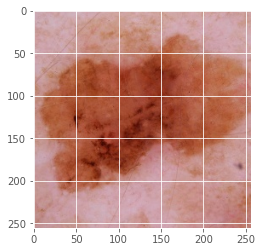

In [21]:
# predict single image
path = './isicdata/train/train/ISIC_0028026.jpg'
image = plt.imread(path)
plt.imshow(image)
image = tf.cast(image, tf.float32) / 255.0
img_size = [256, 256]
image = tf.reshape(image, [*img_size, 3])
image = tf.expand_dims(image, axis=0)
pred = model.predict(image)
print(pred)
plt.title(f'Prediction: {pred[0][0]}')

In [10]:
# import tensorlayer as tl
import numpy as np
import tensorflow as tf

# model.load_weights('./workspace/clientResults/round-1-acc-0.88-weights-2022_07_28-17_30_30.npz')
# weights = np.load('./workspace/clientResults/round-1-acc-0.88-weights-2022_07_28-17_30_30.npz')
# weights_array = dict(zip(("data1A","data1B","data1C"), (weights[k] for k in weights)))
# model.set_weights(weights)

# # save np.load
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = np_load_old(allow_pickle=True)

# w = np.load('./workspace/clientResults/round-1-acc-0.88-weights-2022_07_28-17_30_30.npz', allow_pickle=True)
# w['arr_0']




ValueError: Please specify the "origin" argument (URL of the file to download).